In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/home/jdli/transpec")

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from transGaia.transgaia import xp2label
from transGaia.data import GXP_5lb
from matplotlib.colors import LogNorm
import cmasher as cmr

import matplotlib
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd

rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15
rcParams['font.family'] = 'sans-serif'
%config InlineBackend.figure_format = "retina"

cmap = cmr.dusk

In [2]:
from astropy.stats import bootstrap

boot_stat = lambda x: (np.percentile(x, 14), np.percentile(x, 50), np.percentile(x, 86))

def rmse(res):
    return np.sqrt(np.mean(res**2))

def mae(res):
    return np.median(np.abs(res))

In [367]:
from tqdm import tqdm
import joblib 

scaler_labels = joblib.load('../docs/models/scaler_labels.gz')


def recover_scale_label(y_hat, e_y_hat, bias=2, scale_ext=10):
    y   = scaler_labels.inverse_transform(y_hat/scale_ext-bias)
    e_y = (e_y_hat * scaler_labels.scale_)/scale_ext
    return y, e_y

def recover_dist_label(y_hat, e_y_hat):
    norm = np.array([1e-2, 15., 10., 50.])
    shift_norm = np.array([25., 25., 25., 25.])
    y = (y_hat-shift_norm)/norm
    e_y = e_y_hat/norm
    return y, e_y


def infer_4lbs_model_err(model_name, data_loader, transcale_method=recover_scale_label,
                         n_input=113, n_output=8, n_dim=128, 
                         n_head=8, n_layer=8, device=torch.device('cuda:0')):
    
    model = xp2label(n_encoder_inputs=n_input, n_outputs=n_output, channels=n_dim, n_heads=n_head, n_layers=n_layer).to(device)
    model.load_state_dict(torch.load(model_name))
    
    out_lst, e_out_lst = np.array([]), np.array([])
    id_lst = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            output = model(data['x'])
            out_lst   = np.append(out_lst,   output[:,:4].cpu().numpy())
            e_out_lst = np.append(e_out_lst, output[:,4:].cpu().numpy())
            # y_lst   = np.append(y_lst, data['y'].cpu().numpy())
            id_batch =  list(np.int64(data['id']))
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)

    out_lst, e_out_lst = np.array(out_lst).reshape(-1,4), np.array(e_out_lst).reshape(-1,4)
    # y, e_y = recover_label(out_lst, e_out_lst)
    y, e_y = transcale_method(out_lst, e_out_lst)
    return {'labels':y, 'e_labels':e_y, 'source_id':id_lst}


In [290]:
gdf = pd.read_csv(data_dir+"ap17_gxp_train_81347.csv")

data_dir = "/data/jdli/gaia/"
tr_file = "ap17_wise_xp_66701_allstand1225.npy"
# tr_file = "ap17_wise_xp_66701.npy"

device = torch.device('cuda:0')
TOTAL_NUM = 6000
BATCH_SIZE = 4096

gdata  = GXP_5lb(
    data_dir+tr_file, total_num=TOTAL_NUM, 
    part_train=False,  device=device,
)
gdata_loader = DataLoader(gdata, batch_size=BATCH_SIZE)


In [509]:
# preflix_name = "sp2_4l_robustnorm_mse_{:d}_ep{:d}.pt"
# model_dir =data_dir + "model/1223_4l_err_pen/"

preflix_name = "sp2_4l_allstand_nll_{:d}_ep{:d}.pt"
model_dir = data_dir + "model/1226_4l_err_pen/"
# fold_name = [i for i in range(5)]
# fold_name = [1, 1, 1, 1, 1]
fold_name = [0 for i in range(5)]
epochs = [50]

model_names = [model_dir+preflix_name.format(*[f, e]) for f in fold_name for e in epochs]
print(model_names)


['/data/jdli/gaia/model/1226_4l_err_pen/sp2_4l_allstand_nll_0_ep50.pt', '/data/jdli/gaia/model/1226_4l_err_pen/sp2_4l_allstand_nll_0_ep50.pt', '/data/jdli/gaia/model/1226_4l_err_pen/sp2_4l_allstand_nll_0_ep50.pt', '/data/jdli/gaia/model/1226_4l_err_pen/sp2_4l_allstand_nll_0_ep50.pt', '/data/jdli/gaia/model/1226_4l_err_pen/sp2_4l_allstand_nll_0_ep50.pt']


In [510]:
# from transGaia.inference import *
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
INPUT_LEN = 55*2+3
n_outputs = 8
n_dim = 128
n_head = 8
n_layer = 8
device = torch.device('cuda:0')
rdf_tot = pd.DataFrame([])


for fold, (train_ids, valid_ids) in enumerate(kfold.split(gdata)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    valid_subsampler = SubsetRandomSampler(valid_ids)
    val_loader   = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=valid_subsampler)
    # labels_infer = infer_4lbs_model(model_names[fold], val_loader, device=device)
    labels_infer = infer_4lbs_model_err(model_names[fold], val_loader, device=device)
    
    # rdf = pd.DataFrame(np.c_[labels_infer['labels'], labels_infer['true'][:,1:]], 
    #                    columns=['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross', 
    #                             'teff_true',  'logg_true',  'moh_true', 'aom_true'])
    rdf = pd.DataFrame(np.c_[labels_infer['labels'], labels_infer['e_labels']], 
                        columns=['teff_cross', 'logg_cross',  'moh_cross', 'aom_cross', 
                                'e_teff_cross', 'e_logg_cross', 'e_moh_cross', 'e_aom_cross']
                      )
    rdf = rdf.assign(source_id=labels_infer['source_id'])
    
    # source_id = [gdata[_]['id'] for _ in valid_ids]
#     source_id = retrieve_id(val_loader)
    
#     print(source_id[:5])
#     print(labels_infer['source_id'][:5])
    # rdf = rdf.assign(source_id=source_id)
    rdf_tot = pd.concat([rdf_tot, rdf], ignore_index=True)
    
    print(len(rdf_tot))

FOLD 0
--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


13341
FOLD 1
--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s]


26681
FOLD 2
--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


40021
FOLD 3
--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


53361
FOLD 4
--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


66701


In [463]:
# badname = "ap17_wise_xp_5667bad.npy"

# badata  = GXP_5lb(
#     data_dir+badname, 
#     part_train=False,  device=device,
# )
# bad_loader = DataLoader(badata, batch_size=4096)

# labels_infer = infer_4lbs_model(model_names[0], bad_loader, device=device)
# # bad_labels = recover_labels(labels_infer['labels'])
# bad_ids =   labels_infer['source_id']

# bad_df = pd.DataFrame(labels_infer['labels'], columns=['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross'])
# bad_df = bad_df.assign(source_id=bad_ids)

# rdf_tot = pd.concat([rdf_tot, bad_df], ignore_index=True)
# rdf_tot.shape


In [511]:
out_name = data_dir+"APtransXP_1224_4lbs_err_55coefs.csv"

rdf_tot = rdf_tot.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", suffixes=(None, '_y'))

print(rdf_tot.shape, rdf_tot.columns)

# rdf_tot.to_csv(out_name, index=False)

pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']

rdf_tot = rdf_tot.dropna(subset=pred_names)
rdf_tot.shape

(66701, 54) Index(['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross', 'e_teff_cross',
       'e_logg_cross', 'e_moh_cross', 'e_aom_cross', 'source_id',
       'source_id_y', 'bp_coef', 'e_bp_coef', 'rp_coef', 'e_rp_coef',
       'GAIAEDR3_SOURCE_ID', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR',
       'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
       'GAIAEDR3_PHOT_G_MEAN_MAG', 'GAIAEDR3_PHOT_BP_MEAN_MAG',
       'GAIAEDR3_PHOT_RP_MEAN_MAG', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR',
       'M_H', 'M_H_ERR', 'ALPHA_M', 'ALPHA_M_ERR', 'W1mag', 'W2mag', 'W3mag',
       'W4mag', 'Jmag', 'Hmag', 'Kmag', 'e_W1mag', 'e_W2mag', 'qph_w1',
       'qph_w2', 'Qfl_J', 'Qfl_H', 'Qfl_K', 'snr_bp', 'snr_bp10', 'snr_bp55',
       'snr_rp', 'snr_rp10', 'snr_rp55'],
      dtype='object')


(66701, 54)

0.04269260979150147


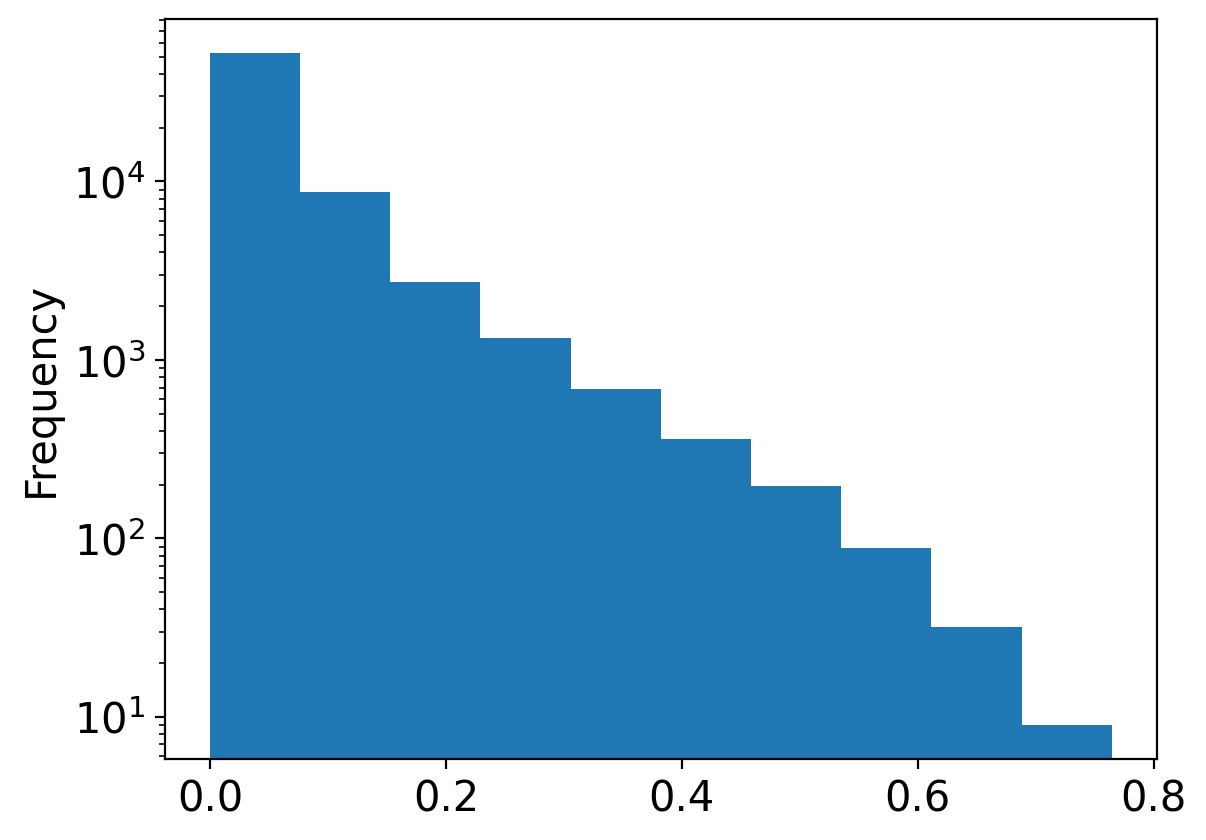

In [512]:
e_pred_name = 'e_moh_cross' # e_teff_cross, e_moh_cross, e_logg_cross, e_aom_cross
rdf_tot[e_pred_name].plot(kind='hist', log=True)
print(np.nanmedian(rdf_tot[e_pred_name]))

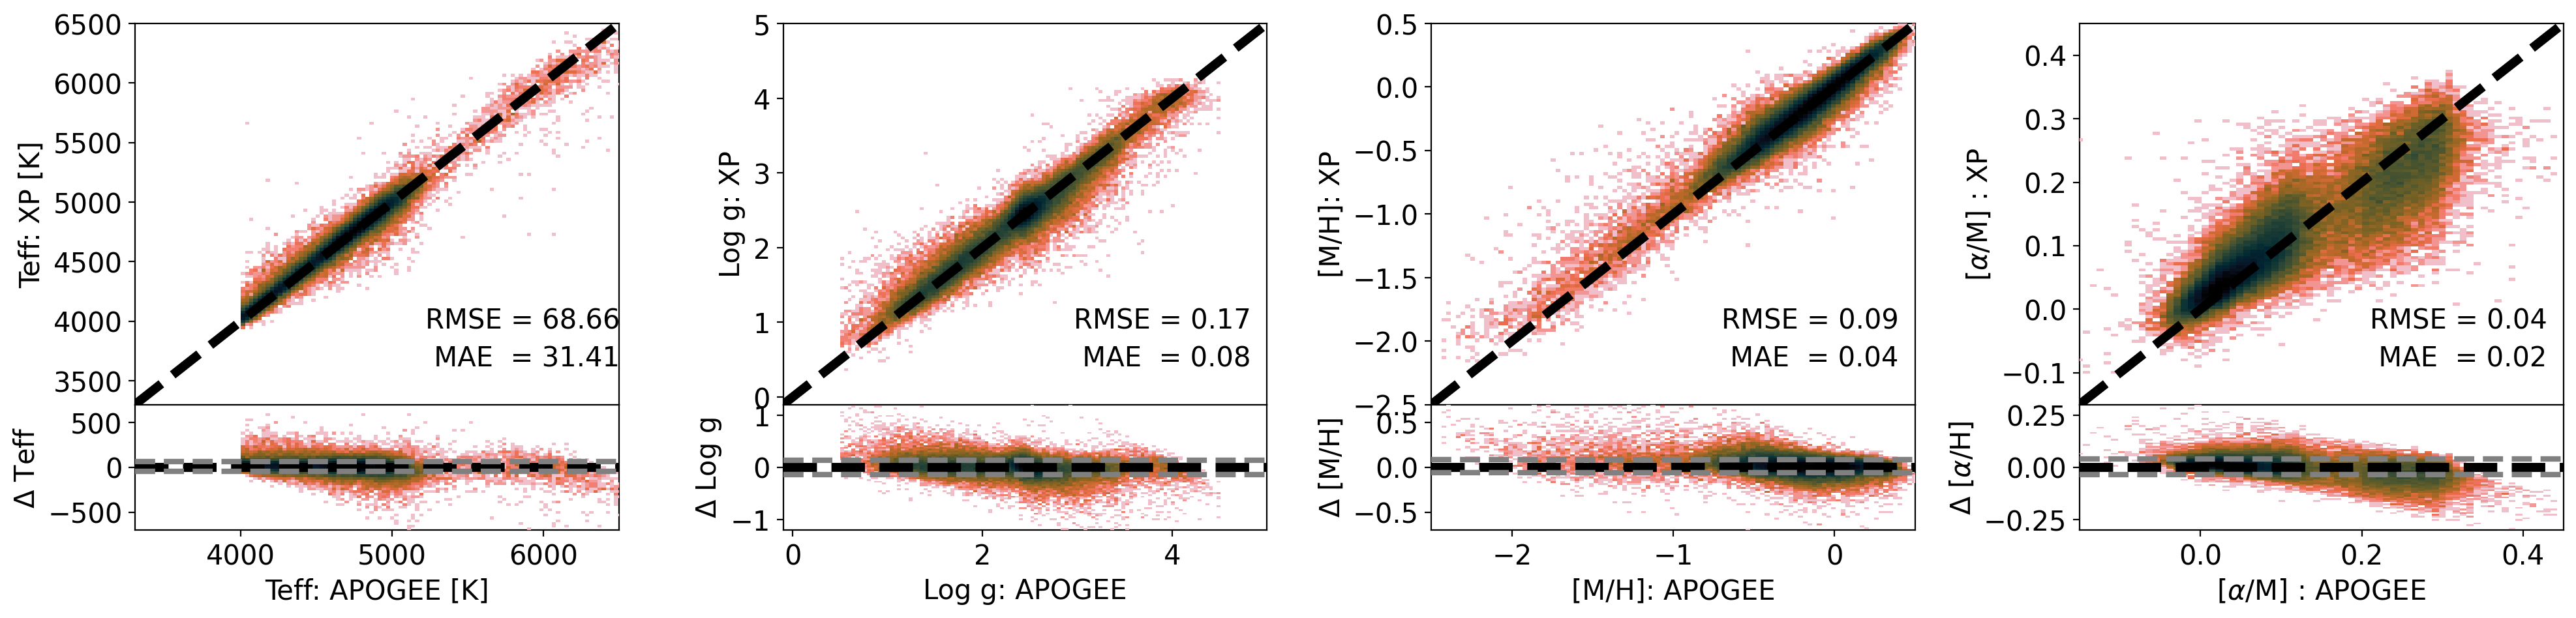

In [513]:
from transGaia.vis import *
rcParams["font.size"] = 15
rcParams['font.family'] = 'sans-serif'


fig, axs = plt.subplots(1,4, figsize=(5*4, 5))

pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']


xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-700, 700],  [-1.2, 1.2],   [-0.7, 0.7], [-0.3, 0.3]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = ['Teff: XP [K]', 'Log g: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']
xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

for i in range(4):
    ax1, ax2 = draw_compare(
        axs[i], rdf_tot[true_names[i]], rdf_tot[pred_names[i]],
        xrange=xranges[i], bins=100,
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);

    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

plt.tight_layout()
# fig.savefig("../fig/compare4d.png")

In [514]:
def chi(pred, tgt, e_pred, e_tgt):
    return (pred-tgt)/np.sqrt(e_pred**2+e_tgt**2)
    
# rdf_tot['e_teff_cross'][rdf_tot['e_teff_cross']<50]=50

pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
e_pred_names = ['e_teff_cross', 'e_logg_cross', 'e_moh_cross', 'e_aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']
e_true_names = ['TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR']
n_pars = len(pred_names)

chi_arr = chi(rdf_tot[pred_names].values, rdf_tot[true_names].values, 
              rdf_tot[e_pred_names].values, rdf_tot[e_true_names].values, )

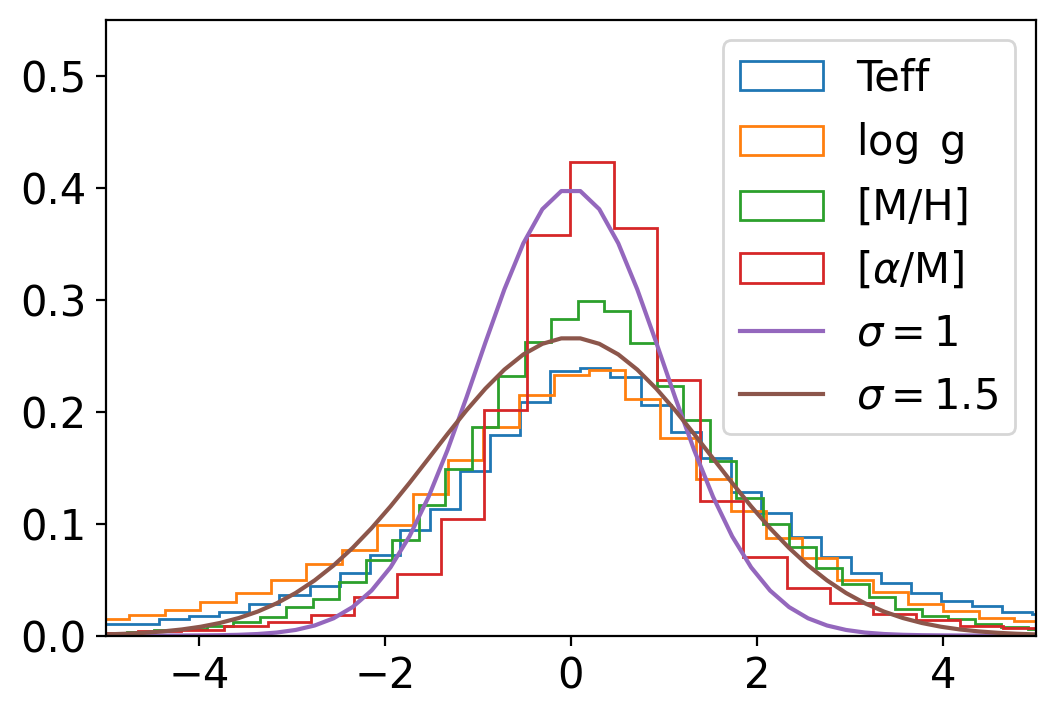

In [515]:
from scipy.stats import norm

labels = ['Teff', r'$\log$ g',  '[M/H]', r'[$\alpha$/M]']

xx = np.linspace(-5, 5)
fig, ax = plt.subplots(1,1, figsize=(6,4))

for i in range(n_pars):
    ax.hist(chi_arr[:,i], histtype='step', label=labels[i], bins=100, density=True)
    ax.set_xlim([-5, 5]);

ax.plot(xx, norm.pdf(xx, loc=0, scale=1), label=r'$\sigma = 1$')
ax.plot(xx, norm.pdf(xx, loc=0, scale=1.5), label=r'$\sigma = 1.5$')
ax.set_ylim([0, 0.55]);
ax.legend();

In [76]:
snr_bp_grids = np.arange(0, 700+100, 100)
snr_rp_grids = np.arange(0, 2000+200, 200)

mask = (rdf_tot['e_moh_cross']<2.) & (rdf_tot['e_aom_cross']<2.) & (rdf_tot['e_logg_cross']<2.)
df_result = rdf_tot[mask].assign(
    snr_bp_bin=pd.cut(rdf_tot[mask]['snr_bp'], bins=snr_bp_grids),
    snr_rp_bin=pd.cut(rdf_tot[mask]['snr_rp'], bins=snr_rp_grids),
)


pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
e_pred_names = ['e_teff_cross', 'e_logg_cross', 'e_moh_cross', 'e_aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']
e_true_names = ['TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR']
n_pars = len(pred_names)
n_boots = 10

chi_arr_bp = np.zeros([n_boots, 3, len(snr_bp_grids)-1, len(pred_names)])
chi_arr_rp = np.zeros([n_boots, 3, len(snr_rp_grids)-1, len(pred_names)])

e_bp = np.zeros([n_boots, 3, len(snr_bp_grids)-1, len(pred_names)])
e_rp = np.zeros([n_boots, 3, len(snr_rp_grids)-1, len(pred_names)])


for i, (gn, group) in enumerate(df_result.groupby(['snr_bp_bin'])):
    print(len(group))
    
    for j in range(n_pars):
        chi_boot = bootstrap(
            np.array((group[pred_names[j]]-group[true_names[j]]) *
                     np.sqrt(group[e_pred_names[j]].values)**2+group[e_true_names[j]].values**2)**-1,
            n_boots, bootfunc=boot_stat
        )
        chi_arr_bp[:,:,i,j] = chi_boot
        
        e_boot = bootstrap(group[e_pred_names[j]].values, n_boots, bootfunc=boot_stat)
        e_bp[:,:,i,j]   = e_boot
        
for i, (gn, group) in enumerate(df_result.groupby(['snr_rp_bin'])):
    print(len(group))
    
    for j in range(n_pars):
        chi_boot = bootstrap(
            np.array((group[pred_names[j]]-group[true_names[j]]) *
                     np.sqrt(group[e_pred_names[j]].values)**2+group[e_true_names[j]].values**2)**-1,
            n_boots, bootfunc=boot_stat
        )
        chi_arr_rp[:,:,i,j] = chi_boot
        
        e_boot = bootstrap(group[e_pred_names[j]].values, n_boots, bootfunc=boot_stat)
        e_rp[:,:,i,j]   = e_boot


230
1839
6787
23753
23334
7856
2096
82
1683
7827
15220
19768
14489
5236
1524
479
146


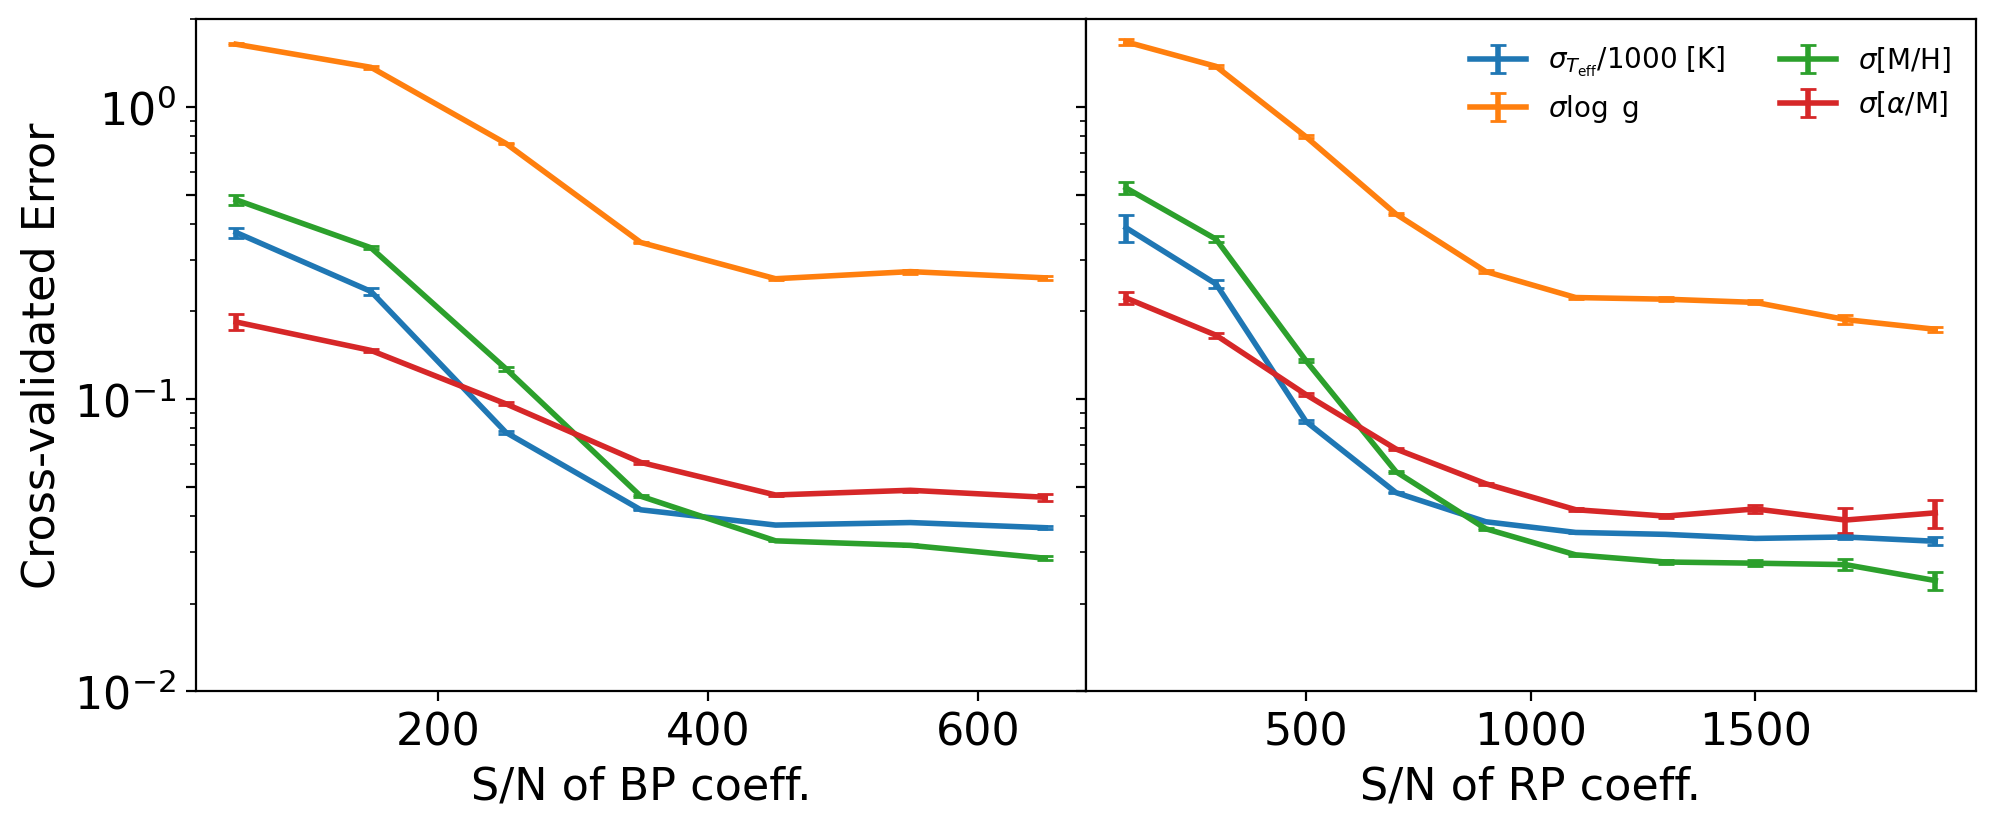

In [86]:
labels = ['Teff', r'$\log$ g',  '[M/H]', r'[$\alpha$/M]']

snr_bp_mids = snr_bp_grids[:-1]+np.diff(snr_bp_grids)*0.5
snr_rp_mids = snr_rp_grids[:-1]+np.diff(snr_rp_grids)*0.5
colors_seq = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
ft = 16
rcParams["font.size"] = ft
rcParams['font.family'] = 'sans-serif'
ax1, ax2 = axs.ravel()

for i in range(len(labels)):
    if i==0:
        ax1.errorbar(
            snr_bp_mids, 
            1e-3*np.mean(e_bp[:,1,:,i], axis=0), 1e-3*np.std(e_bp[:,1,:,i], axis=0),
            label=r"$\sigma_{T_{\rm eff}}$/1000 [K]", fmt='-', capsize=3, lw=2, color=colors_seq[i]
        )
        ax2.errorbar(
            snr_rp_mids, 
            1e-3*np.mean(e_rp[:,1,:,i], axis=0), 1e-3*np.std(e_rp[:,1,:,i], axis=0), 
            label=r"$\sigma_{T_{\rm eff}}$/1000 [K]", fmt='-', capsize=3, lw=2, color=colors_seq[i]
        )
    elif i>0:
        ax1.errorbar(
            snr_bp_mids, np.mean(e_bp[:,1,:,i], axis=0), np.std(e_bp[:,1,:,i], axis=0),
            label=r"$\sigma$"+labels[i], fmt='-', capsize=3, lw=2,  color=colors_seq[i]
        )
        ax2.errorbar(
            snr_rp_mids, np.mean(e_rp[:,1,:,i], axis=0), np.std(e_rp[:,1,:,i], axis=0), 
            label=r"$\sigma$"+labels[i], fmt='-', capsize=3, lw=2, color=colors_seq[i]
        )
    # ax1.errorbar(
    #     snr_bp_mids, np.mean(chi_arr_bp[:,1,:,i], axis=0), yerr=np.std(chi_arr_bp[:,1,:,i], axis=0), 
    #     label=r"$chi$"+labels[i], fmt='-', capsize=3, lw=2,  color=colors_seq[i]
    # )
    # ax2.errorbar(
    #     snr_rp_mids, np.mean(chi_arr_rp[:,1,:,i], axis=0), yerr=np.std(chi_arr_rp[:,1,:,i], axis=0), 
    #     label=r"$chi$"+labels[i], fmt='-', capsize=3, lw=2,  color=colors_seq[i]
    # )
    
    
ax2.legend(fontsize=10, frameon=False, ncol=2);
for ax in axs.ravel():
    # ax.legend(fontsize=12, frameon=False, ncol=4);
    ax.set_ylim([1e-2, 2]);
    ax.set_yscale('log')
    ax.set_yticks([0.01, 0.05, 0.1, 0.5, 1.])
    
ax1.set_ylabel('Cross-validated Error')
ax1.set_xlabel("S/N of BP coeff.");
ax2.set_xlabel("S/N of RP coeff.");


fig.subplots_adjust(left=0.1, bottom=0.15, right=0.99, top=0.99, wspace=0, hspace=0)
# plt.tight_layout()
# fig.savefig("../fig/cv_error.pdf")

In [82]:
snr_bp_grids = np.arange(0, 700+100, 100)
snr_rp_grids = np.arange(0, 2000+200, 200)


df_result = rdf_tot.assign(
    snr_bp_bin=pd.cut(rdf_tot['snr_bp'], bins=snr_bp_grids),
    snr_rp_bin=pd.cut(rdf_tot['snr_rp'], bins=snr_rp_grids),
)

pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']
e_true_names = ['TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR']
n_pars = len(pred_names)
n_boots = 10

# chi_arr_bp = np.zeros([n_boots, 3, len(snr_bp_grids)-1, len(pred_names)])
# chi_arr_rp = np.zeros([n_boots, 3, len(snr_rp_grids)-1, len(pred_names)])
rmse_bp = np.zeros([n_boots, len(snr_bp_grids)-1, len(pred_names)])
rmse_rp = np.zeros([n_boots, len(snr_rp_grids)-1, len(pred_names)])
mae_bp  = np.zeros([n_boots, len(snr_bp_grids)-1, len(pred_names)])
mae_rp  = np.zeros([n_boots, len(snr_rp_grids)-1, len(pred_names)])

for i, (gn, group) in enumerate(df_result.groupby(['snr_bp_bin'])):
    print(len(group))
    
    for j in range(n_pars):
        group_boot = bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])/group[e_true_names[j]]),
                               n_boots, bootfunc=boot_stat)
        # chi_arr_bp[:,:,i,j] = group_boot
        rmse_bp[:,i,j] =  bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])),
                               n_boots, bootfunc=rmse)
        mae_bp[:,i,j] =   bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])),
                               n_boots, bootfunc=mae)
        
for i, (gn, group) in enumerate(df_result.groupby(['snr_rp_bin'])):
    print(len(group))
    
    for j in range(n_pars):
        group_boot = bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])/group[e_true_names[j]]),
                               n_boots, bootfunc=boot_stat)
        # chi_arr_rp[:,:,i,j] = group_boot
        rmse_rp[:,i,j] =  bootstrap(np.array(group[pred_names[j]]-group[true_names[j]]),
                               n_boots, bootfunc=rmse)
        mae_rp[:,i,j] =   bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])),
                               n_boots, bootfunc=mae)

262
1925
6831
23773
23338
7856
2096
107
1776
7879
15233
19771
14489
5237
1524
479
146


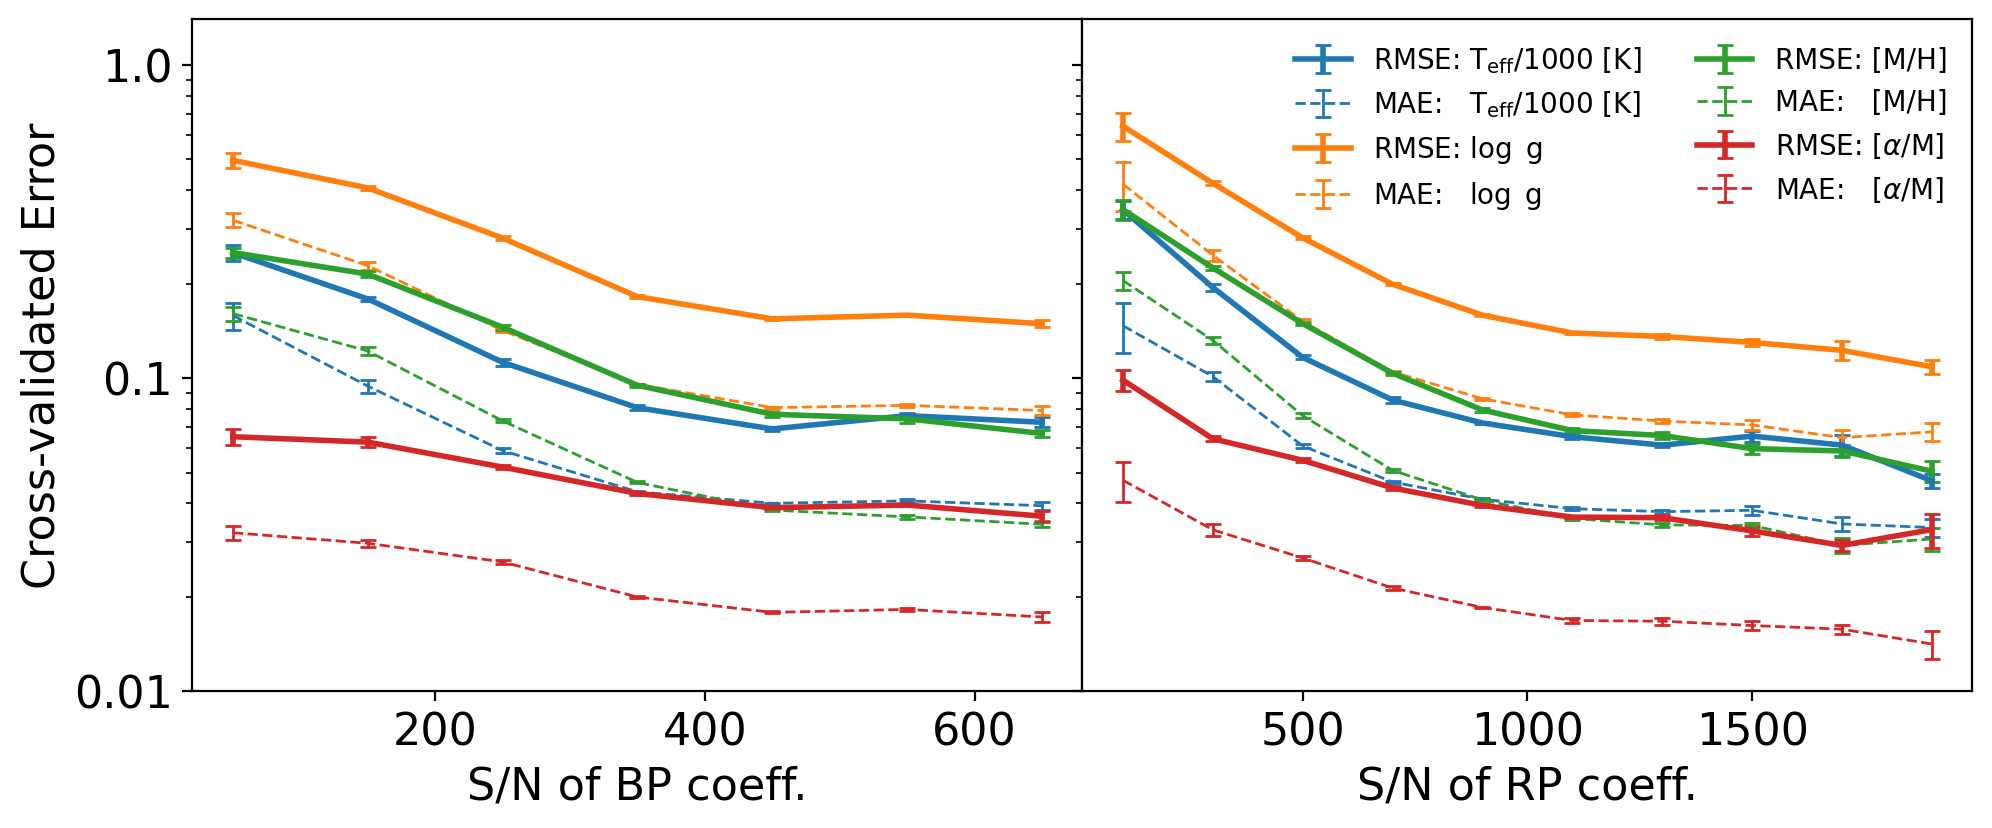

In [91]:
# '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'

labels = ['Teff', r'$\log$ g',  '[M/H]', r'[$\alpha$/M]']

snr_bp_mids = snr_bp_grids[:-1]+np.diff(snr_bp_grids)*0.5
snr_rp_mids = snr_rp_grids[:-1]+np.diff(snr_rp_grids)*0.5
colors_seq = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
ft = 16
rcParams["font.size"] = ft
rcParams['font.family'] = 'sans-serif'
ax1, ax2 = axs.ravel()

for i in range(len(labels)):
    if i==0:
        ax1.errorbar(
            snr_bp_mids, 
            1e-3*np.mean(rmse_bp[:,:,i], axis=0), 1e-3*np.std(rmse_bp[:,:,i], axis=0),
            label=r"RMSE: T$_{\rm eff}$/1000 [K]", fmt='-', capsize=3, lw=2, color=colors_seq[i]
        )
        ax2.errorbar(
            snr_rp_mids, 
            1e-3*np.mean(rmse_rp[:,:,i], axis=0), 1e-3*np.std(rmse_rp[:,:,i], axis=0), 
            label=r"RMSE: T$_{\rm eff}$/1000 [K]", fmt='-', capsize=3, lw=2, color=colors_seq[i]
        )
        ax1.errorbar(
            snr_bp_mids, 
            1e-3*np.mean(mae_bp[:,:,i], axis=0), 1e-3*np.std(mae_bp[:,:,i], axis=0), 
            label=r"MAE:   T$_{\rm eff}$/1000 [K]", fmt='--', capsize=3, lw=1, color=colors_seq[i]
        )
        ax2.errorbar(
            snr_rp_mids, 
            1e-3*np.mean(mae_rp[:,:,i], axis=0), 1e-3*np.std(mae_rp[:,:,i], axis=0), 
            label=r"MAE:   T$_{\rm eff}$/1000 [K]", fmt='--', capsize=3, lw=1, color=colors_seq[i]
        )
    elif i>0:
        ax1.errorbar(
            snr_bp_mids, np.mean(rmse_bp[:,:,i], axis=0), np.std(rmse_bp[:,:,i], axis=0),
            label="RMSE: "+labels[i], fmt='-', capsize=3, lw=2,  color=colors_seq[i]
        )
        ax2.errorbar(
            snr_rp_mids, np.mean(rmse_rp[:,:,i], axis=0), np.std(rmse_rp[:,:,i], axis=0), 
            label="RMSE: "+labels[i], fmt='-', capsize=3, lw=2, color=colors_seq[i]
        )
        ax1.errorbar(
            snr_bp_mids, np.mean(mae_bp[:,:,i], axis=0), np.std(mae_bp[:,:,i], axis=0), 
            label="MAE:   "+labels[i], fmt='--', capsize=3, lw=1, color=colors_seq[i]
        )
        ax2.errorbar(
            snr_rp_mids, np.mean(mae_rp[:,:,i], axis=0), np.std(mae_rp[:,:,i], axis=0), 
            label="MAE:   "+labels[i], fmt='--', capsize=3, lw=1, color=colors_seq[i]
        )

ax2.legend(fontsize=10, frameon=False, ncol=2);
for ax in axs.ravel():
    # ax.legend(fontsize=12, frameon=False, ncol=4);
    ax.set_ylim([1e-2, 1.4]);
    ax.set_yscale('log')
    # ax.set_xscale('log')

ax1.set_yticks([0.01, 0.1,  1.])
ax1.set_yticklabels([0.01, 0.1,  1.])
ax1.set_ylabel('Cross-validated Error')
ax1.set_xlabel("S/N of BP coeff.");
ax2.set_xlabel("S/N of RP coeff.");


fig.subplots_adjust(left=0.1, bottom=0.15, right=0.99, top=0.99, wspace=0, hspace=0)
# plt.tight_layout()
# fig.savefig("../fig/cv_error.pdf")

In [12]:
# teff_grid = [4000, 4250, 4500, 4750, 5000, 6000, 7000]
def boots_from_parbins(df, pred_name, true_name, pars_name, par_grids, n_boots=10):
    pars_bin_name = pars_name + "_bin"
    
    rmse_arr = np.nan*np.zeros([n_boots, len(par_grids)-1])
    
    df[pars_bin_name]=pd.cut(df[pars_name], bins=par_grids)

    for i, (_,g) in enumerate(df.groupby(pars_bin_name)):
        # print(len(g))
        rmse_arr[:,i] =  bootstrap(np.array((g[pred_name]-g[true_name])), n_boots, bootfunc=rmse)

    return rmse_arr
    

# teff_grid = np.arange(4000, 7000, 250)
# alpha_rmse_teff = boots_from_parbins(rdf_tot, 'aom_cross', 'ALPHA_M', 'TEFF', teff_grid)

# plt.errorbar(teff_grid[:-1], np.mean(alpha_rmse_teff, axis=0), np.std(alpha_rmse_teff, axis=0), )

<ErrorbarContainer object of 3 artists>

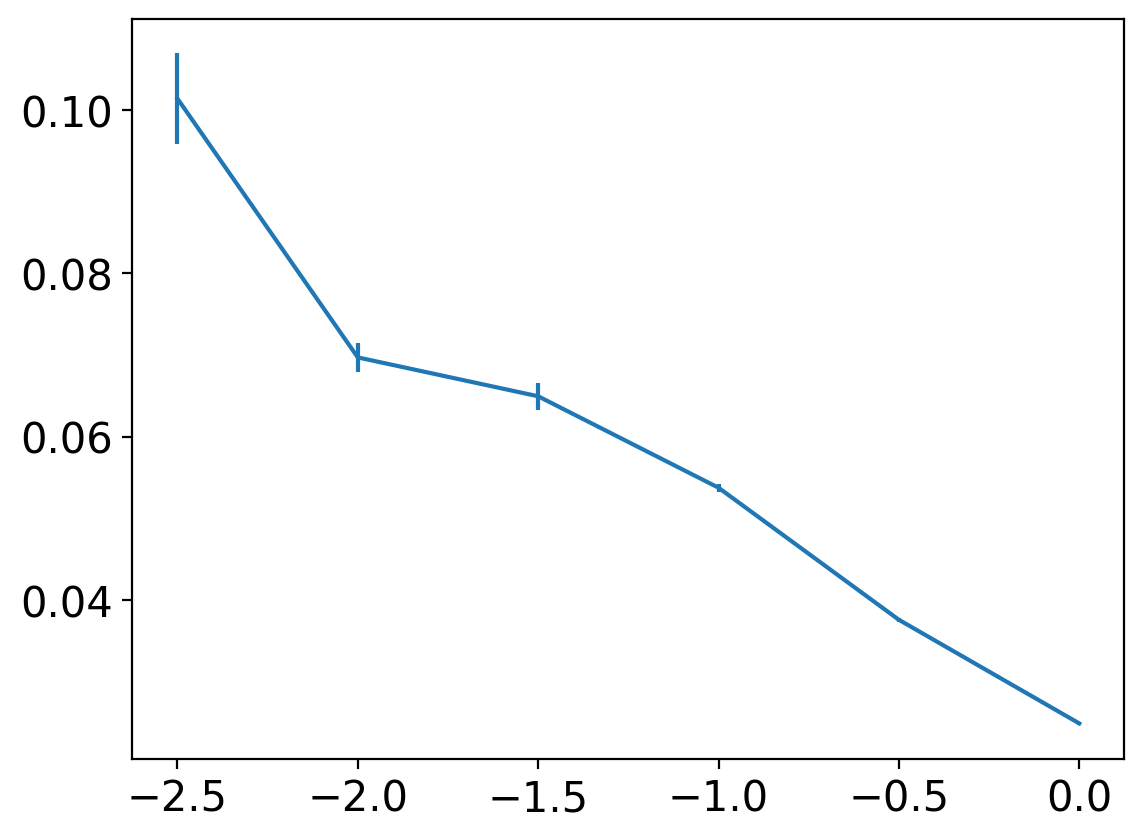

In [213]:
# moh_grid = np.arange(-2.5, 0.7, 0.5)
# alpha_rmse_moh = boots_from_parbins(rdf_tot, 'aom_cross', 'ALPHA_M', 'M_H', moh_grid)

# plt.errorbar(moh_grid[:-1], np.mean(alpha_rmse_moh, axis=0), np.std(alpha_rmse_moh, axis=0), )

In [13]:


def mids_from_grids(x):
    return x[:-1]+np.diff(x)*0.5


snr_bp_grids   = np.arange(0, 800+100, 100)
snr_rp_grids   = np.arange(0, 2000+100, 100)
snr_bp10_grids = np.arange(0, 1000+200, 200)
snr_rp10_grids = np.arange(0, 3000+200, 200)
snr_bp55_grids = np.linspace(0, 4, 11)
snr_rp55_grids = np.linspace(0, 10, 21)

snr_bp_mids = mids_from_grids(snr_bp_grids)
snr_rp_mids = mids_from_grids(snr_rp_grids)
snr_bp10_mids = mids_from_grids(snr_bp10_grids)
snr_rp10_mids = mids_from_grids(snr_rp10_grids)
snr_bp55_mids = mids_from_grids(snr_bp55_grids)
snr_rp55_mids = mids_from_grids(snr_rp55_grids)


alpha_rmse = {}
alpha_rmse['bp'] = boots_from_parbins(rdf_tot, 'aom_cross', 'ALPHA_M', 'snr_bp', snr_bp_grids)
alpha_rmse['rp'] = boots_from_parbins(rdf_tot, 'aom_cross', 'ALPHA_M', 'snr_rp', snr_rp_grids)
alpha_rmse['bp10'] = boots_from_parbins(rdf_tot, 'aom_cross', 'ALPHA_M', 'snr_bp10', snr_bp10_grids)
alpha_rmse['rp10'] = boots_from_parbins(rdf_tot, 'aom_cross', 'ALPHA_M', 'snr_rp10', snr_rp10_grids)
alpha_rmse['bp55'] = boots_from_parbins(rdf_tot, 'aom_cross', 'ALPHA_M', 'snr_bp55', snr_bp55_grids)
alpha_rmse['rp55'] = boots_from_parbins(rdf_tot, 'aom_cross', 'ALPHA_M', 'snr_rp55', snr_rp55_grids)


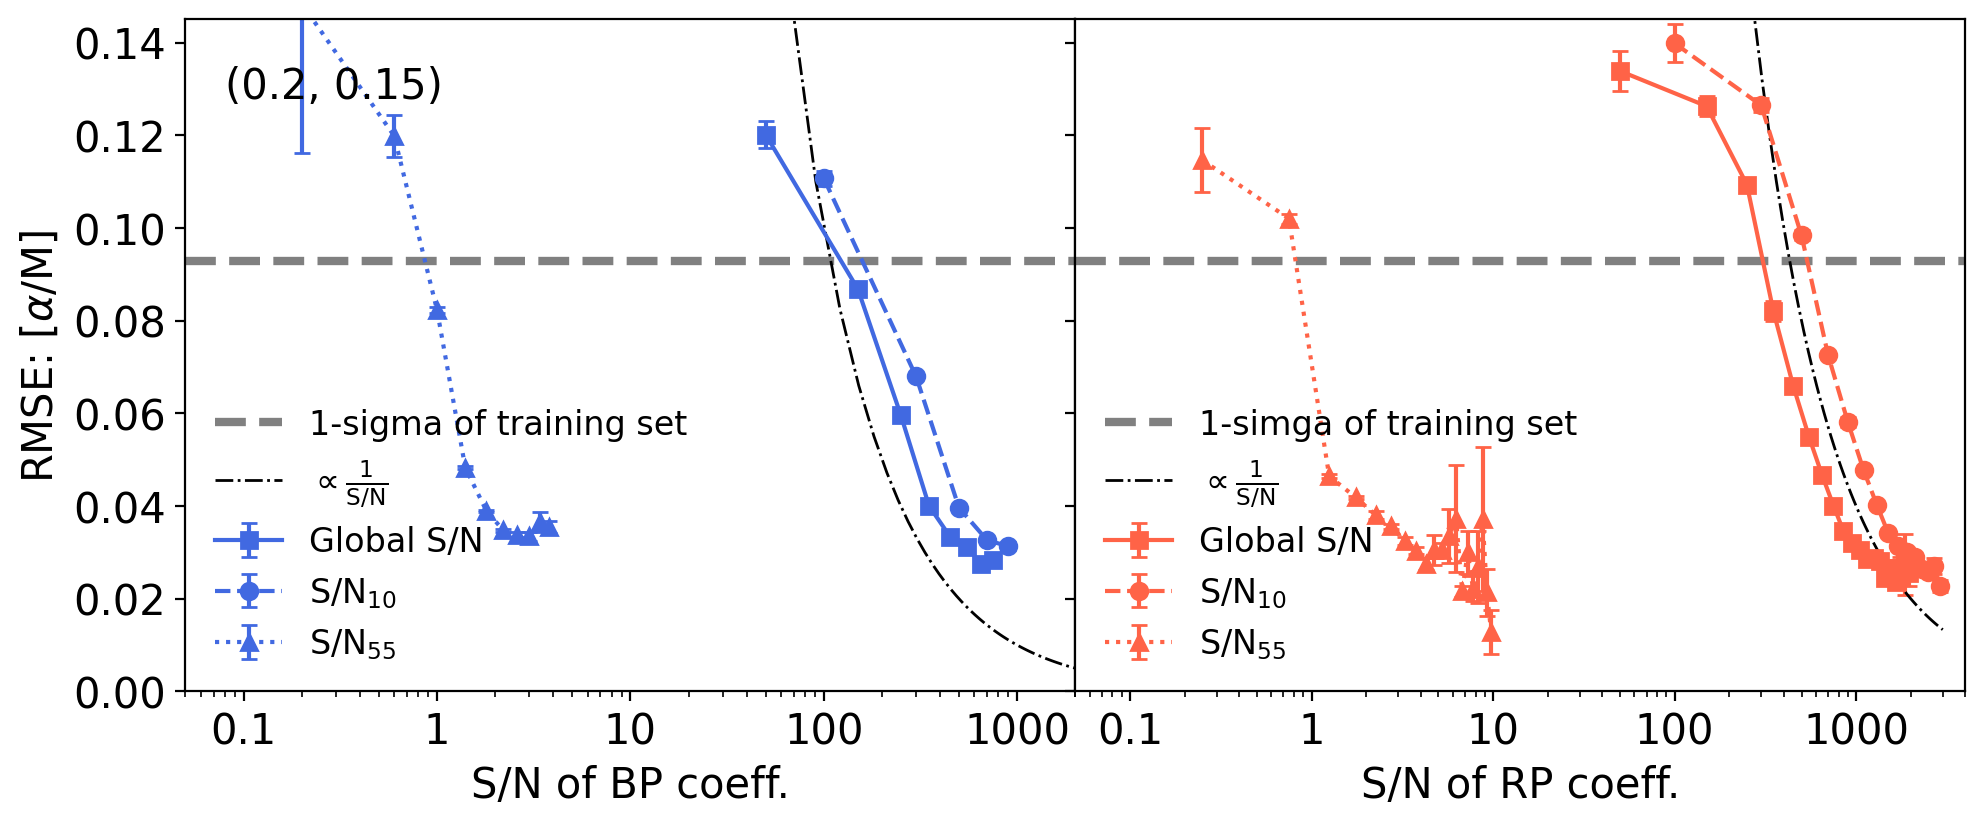

In [45]:
snr_grids_ = np.linspace(1e-3, 3000, 100)


fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax1, ax2 = axs.ravel()


ax1.errorbar(
    snr_bp_mids, 
    np.mean(alpha_rmse['bp'], axis=0), np.std(alpha_rmse['bp'], axis=0),
     fmt='s-', capsize=3, c='royalblue', label='Global S/N'
)
ax1.errorbar(
    snr_bp10_mids, 
    np.mean(alpha_rmse['bp10'], axis=0), np.std(alpha_rmse['bp10'], axis=0),
     fmt='o--', capsize=3, c='royalblue', label=r'S/N$_{10}$'
)
ax1.errorbar(
    snr_bp55_mids, 
    np.mean(alpha_rmse['bp55'], axis=0), np.std(alpha_rmse['bp55'], axis=0),
     fmt='^:', capsize=3, c='royalblue', label=r'S/N$_{55}$'
)
ax1.set_xscale('log')

ax1.set_xlabel("S/N of BP coeff.");
ax1.set_ylabel(r"RMSE: [$\alpha$/M]");


ax2.errorbar(
    snr_rp_mids, 
    np.mean(alpha_rmse['rp'], axis=0), np.std(alpha_rmse['rp'], axis=0),
     fmt='s-', capsize=3, c='tomato', label='Global S/N'
)
ax2.errorbar(
    snr_rp10_mids, 
    np.mean(alpha_rmse['rp10'], axis=0), np.std(alpha_rmse['rp10'], axis=0),
     fmt='o--', capsize=3, c='tomato', label=r'S/N$_{10}$'
)
ax2.errorbar(
    snr_rp55_mids, 
    np.mean(alpha_rmse['rp55'], axis=0), np.std(alpha_rmse['rp55'], axis=0),
    fmt='^:', capsize=3, c='tomato', label=r'S/N$_{55}$'
)

ax2.set_xlabel("S/N of RP coeff.");
ax2.set_xscale('log')

ax1.axhline(y=np.std(rdf_tot['ALPHA_M']), lw=3, ls='--', color='grey',
            label="1-sigma of training set")
ax2.axhline(y=np.std(rdf_tot['ALPHA_M']), lw=3, ls='--', color='grey',
            label="1-simga of training set")

ax1.plot(snr_grids_, 10/snr_grids_, ls='-.', lw=1, c='k', label=r'$\propto \frac{1}{\rm S/N}$')
ax2.plot(snr_grids_, 40/snr_grids_, ls='-.', lw=1, c='k', label=r'$\propto \frac{1}{\rm S/N}$')

ax1.set_ylim([0, 0.145]);
ax2.set_ylim([0, 0.145]);
ax1.set_xlim([0.05, 2000]);
ax2.set_xlim([0.05, 4000]);

ax1.set_xticks([0.1, 1, 10, 100, 1000]);
ax1.set_xticks([0.1, 1, 10, 100, 1000]);
ax1.set_xticklabels([0.1, 1, 10, 100, 1000]);
ax1.set_xticklabels([0.1, 1, 10, 100, 1000]);
ax2.set_xticks([0.1, 1, 10, 100, 1000]);
ax2.set_xticks([0.1, 1, 10, 100, 1000]);
ax2.set_xticklabels([0.1, 1, 10, 100, 1000]);
ax2.set_xticklabels([0.1, 1, 10, 100, 1000]);

ax1.legend(loc=3, fontsize=12, frameon=False, ncol=1);
ax2.legend(loc=3, fontsize=12, frameon=False, ncol=1);
ax1.annotate("(0.2, 0.15)", (0.08, 0.128), xycoords='data')

plt.tight_layout()
fig.subplots_adjust(left=0.1, bottom=0.15, right=0.99, top=0.99, wspace=0, hspace=0)

fig.savefig("../fig/rsme_alpha.pdf")

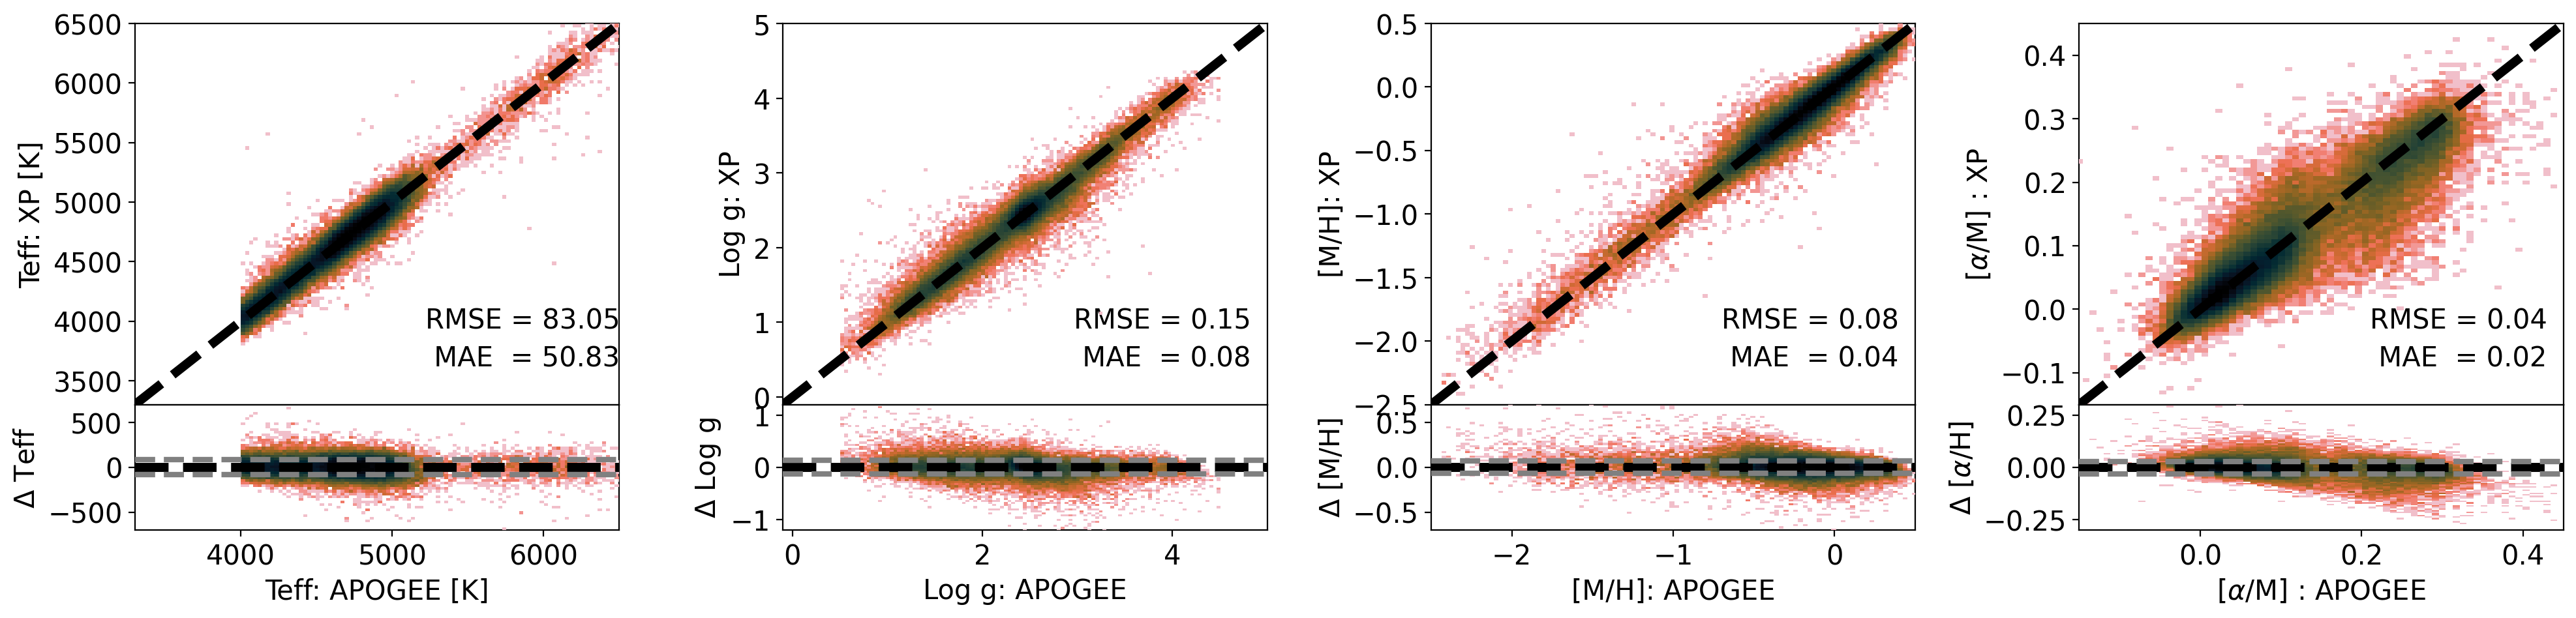

In [26]:

from transGaia.vis import *

plot_mask = (rdf_tot['snr_bp55']>1) &  (rdf_tot['snr_rp55']>1)  & (rdf_tot['snr_bp']>100) & (rdf_tot['snr_rp']>100)
             
rcParams["font.size"] = 15
rcParams['font.family'] = 'sans-serif'

fig, axs = plt.subplots(1,4, figsize=(5*4, 5))

pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-700, 700],  [-1.2, 1.2],   [-0.7, 0.7], [-0.3, 0.3]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = ['Teff: XP [K]', 'Log g: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']
xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

for i in range(4):
    ax1, ax2 = draw_compare(
        axs[i], rdf_tot[plot_mask][true_names[i]], rdf_tot[plot_mask][pred_names[i]],
        xrange=xranges[i], bins=100,
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

plt.tight_layout()

fig.savefig("../fig/compare4d.png")


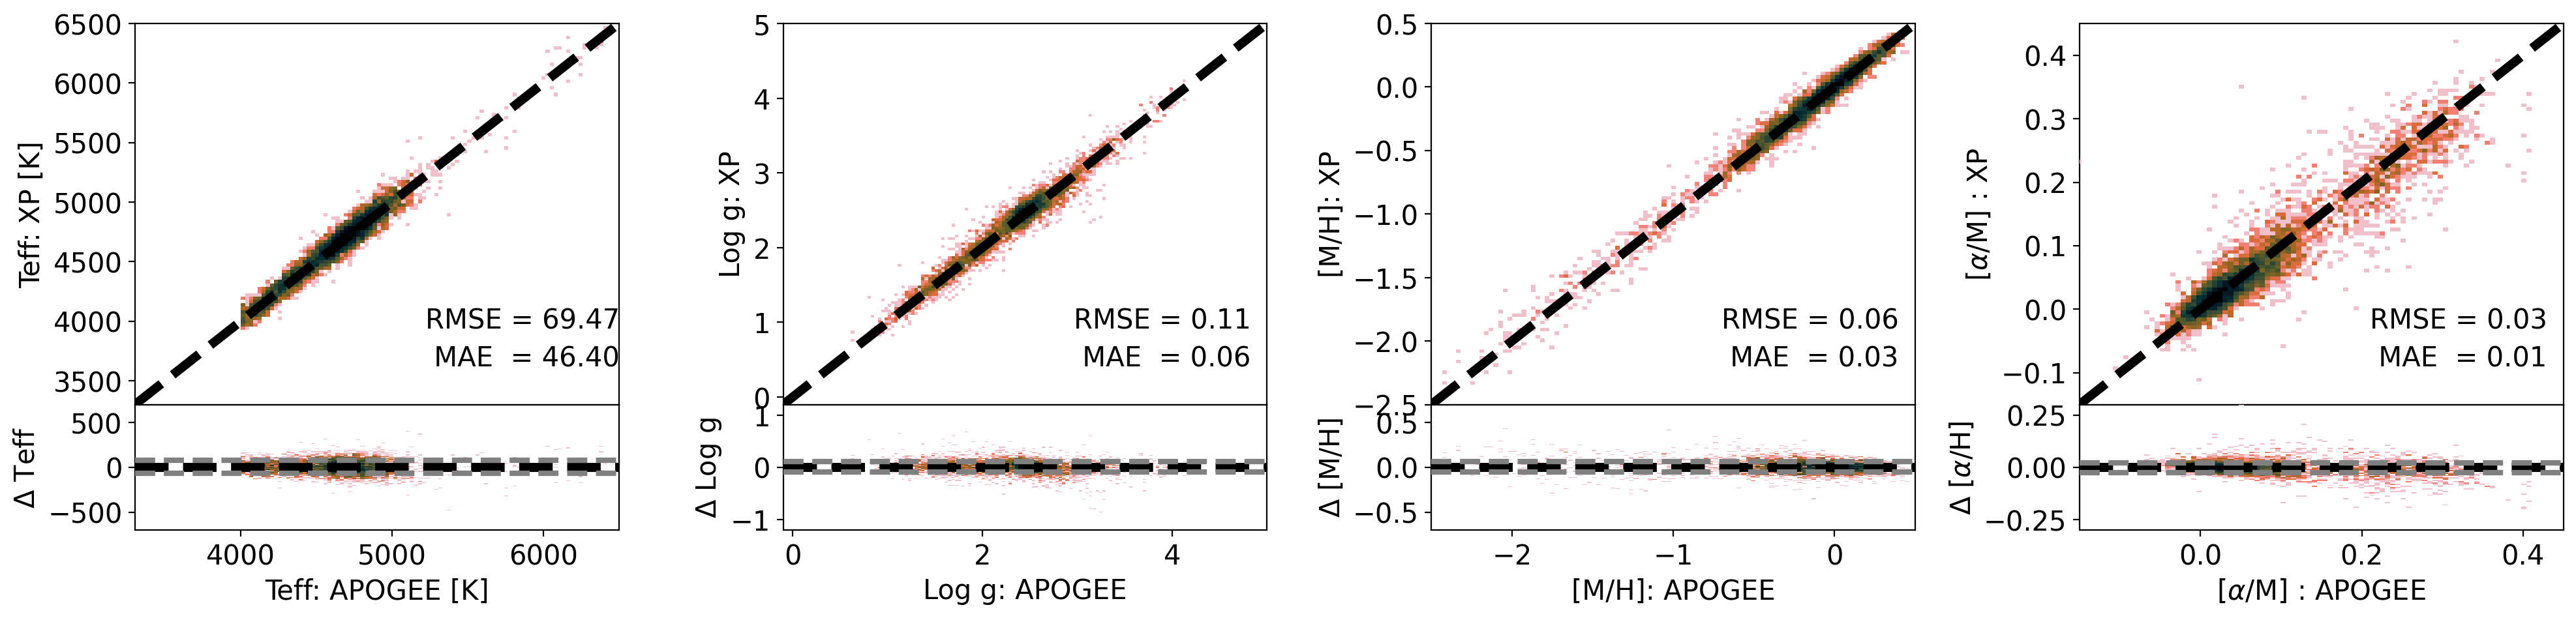

In [27]:
from transGaia.vis import *

plot_mask = (rdf_tot['snr_bp55']>2) &  (rdf_tot['snr_rp55']>2)  & (rdf_tot['snr_bp']>500) & (rdf_tot['snr_rp']>500)
             
rcParams["font.size"] = 15
rcParams['font.family'] = 'sans-serif'

fig, axs = plt.subplots(1,4, figsize=(5*4, 5))

pred_names = ['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-700, 700],  [-1.2, 1.2],   [-0.7, 0.7], [-0.3, 0.3]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = ['Teff: XP [K]', 'Log g: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']
xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

for i in range(4):
    ax1, ax2 = draw_compare(
        axs[i], rdf_tot[plot_mask][true_names[i]], rdf_tot[plot_mask][pred_names[i]],
        xrange=xranges[i], bins=100,
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

plt.tight_layout()

fig.savefig("../fig/compare4d_hisnr.png")


# draw attention map of 1 label

In [86]:
from transGaia.vis import *
from transGaia.inference import *


In [47]:
data_dir = "/data/jdli/gaia/"
tr_file = "ap17_wise_xp_66701.npy"

device = torch.device('cuda:0')
TOTAL_NUM = 6000
BATCH_SIZE = 512

gdata  = GXP_5lb(
    data_dir+tr_file, total_num=TOTAL_NUM, 
    part_train=False,  device=device,
)
gdata_loader = DataLoader(gdata, batch_size=4096)

In [89]:
model_dir = "/data/jdli/gaia/model/1207_alpha/A/sp2_ALPHA_M_robustnorm_mse_A_ep200.pt"

model_a = xp2label(
    n_encoder_inputs=INPUT_LEN, 
    n_outputs=1, 
    channels=n_dim, 
    n_heads=n_head, attn=True, 
    n_layers=n_layer).to(device)

model_a.load_state_dict(torch.load(model_dir))


<All keys matched successfully>

In [90]:
model_dir = "/data/jdli/gaia/model/1205_teff/A/sp2_teff_robustnorm_mse_A_ep200.pt"

model_t = xp2label(
    n_encoder_inputs=INPUT_LEN, 
    n_outputs=1, 
    channels=n_dim, 
    n_heads=n_head, attn=True, 
    n_layers=n_layer).to(device)

model_t.load_state_dict(torch.load(model_dir))


<All keys matched successfully>

In [91]:
def predict_label_attn(data_loader, model, n_label=1, attn=True):
    out_lst = np.array([])
    # attn_all = np.array([])
    attn_all, id_lst = [], []

    with torch.no_grad():

        for data in tqdm(data_loader):
            
            id_batch =  list(np.int64(data['id']))
            for idl in id_batch:
                id_lst.append(idl)

            if attn:
                output, att = model(data['x'])
                out_lst = np.append(out_lst, output.cpu().numpy())
                attn_all.append([a.cpu().numpy().reshape(-1,113,113) for a in att])
                # attn_batch = np.array([a.cpu().numpy().reshape(-1,113,113) for a in att])
                # attn_all = np.append(attn_all, attn_batch.reshape(-1,8,113,113))
            else:
                output = model(data['x'])
                out_lst = np.append(out_lst, output.cpu().numpy())
                attn_all = None
                
            del output, data
                
    out_lst = np.array(out_lst).reshape(-1, n_label)

    return {'labels':out_lst, 'source_id':id_lst, 'attn':attn_all}

In [92]:
aom_infer = predict_label_attn(gdata_loader, model_a)
teff_infer = predict_label_attn(gdata_loader, model_t)


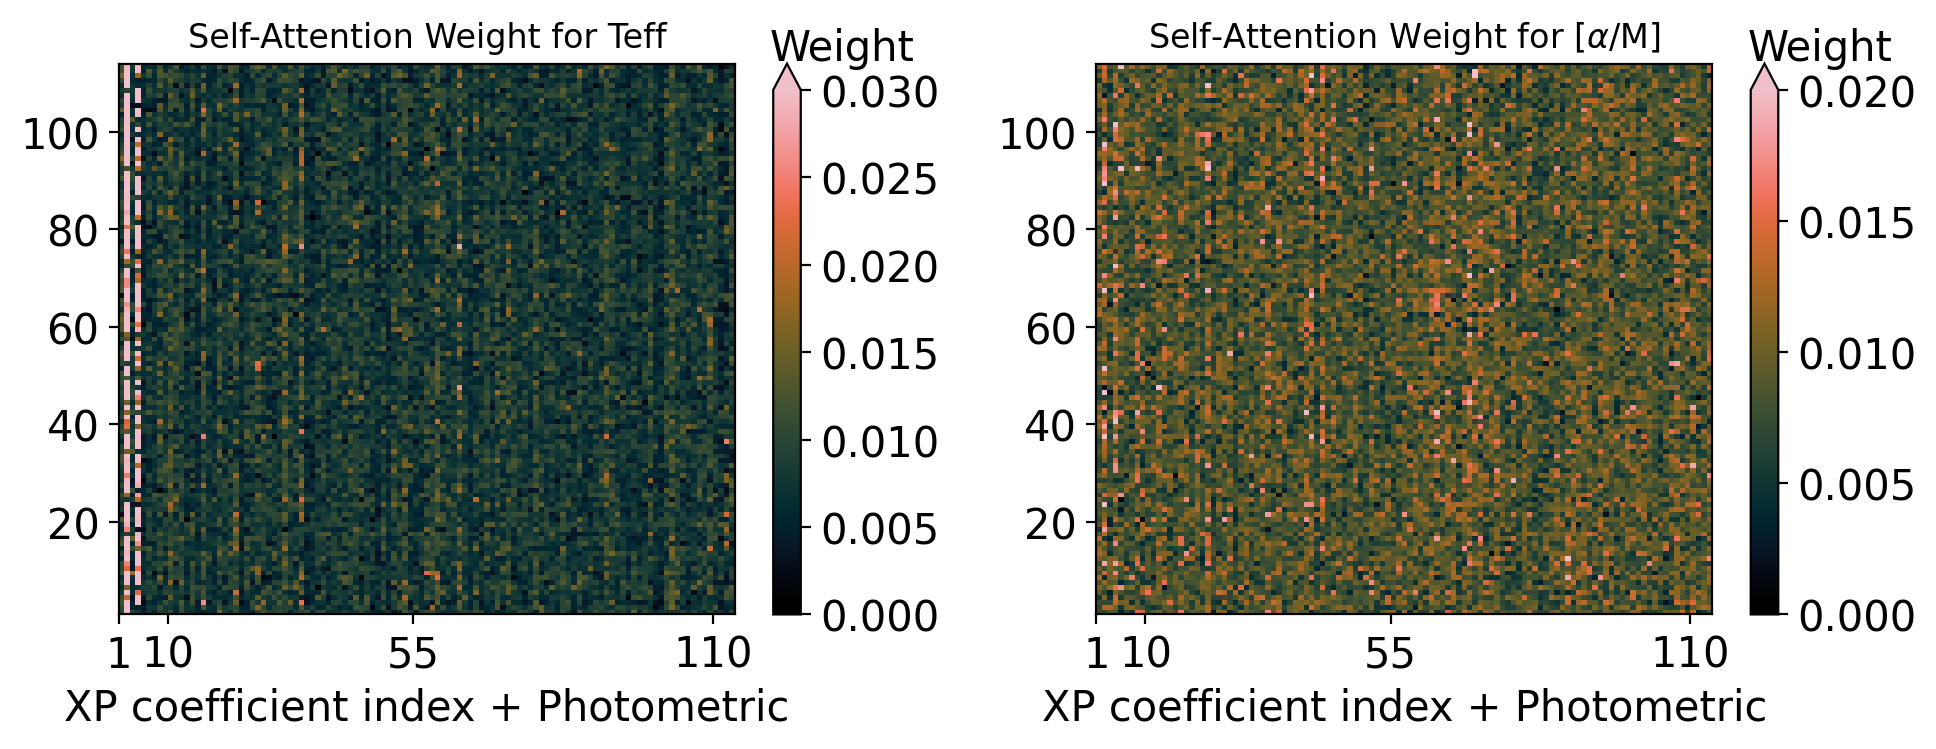

In [93]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

idx = 5
layer = 0
batch_idx = 0

ax1, ax2 = axs.ravel()
ax1 = draw_attention(teff_infer['attn'][batch_idx][layer][idx], ax1, vmax=0.03, cmap='cmr.dusk')
ax1.set_title("Self-Attention Weight for Teff", fontsize=12);

ax2 = draw_attention(aom_infer['attn'][batch_idx][layer][idx], ax2, vmax=0.02, cmap='cmr.dusk')
ax2.set_title(r"Self-Attention Weight for [$\alpha$/M]", fontsize=12);
plt.tight_layout()

In [130]:
def draw_attention(attn, ax, vmax=0.03, cmap='cmr.eclipse'):
    num_coeff_grid = np.linspace(1,114,114)
    xx, yy = np.meshgrid(num_coeff_grid, num_coeff_grid)
    img = ax.pcolormesh(
        xx, yy, attn, 
        norm=colors.Normalize(vmin=0, vmax=vmax), 
        cmap=cmap, shading="flat"
    )
    # ax.set_xscale('log')
    ax.set_xticks([1, 10, 55, 110]);
    ax.set_xticklabels([1, 10, 55, 110]);

    clb = plt.colorbar(img, ax=ax, extend='max');
    clb.set_label(r"Weight", rotation=0, y=1.15, labelpad=-35)

    ax.set_xlabel("XP coefficient index + Photometric");
    return ax

In [145]:
teff_infer['source_id'][5]

422588227468979328

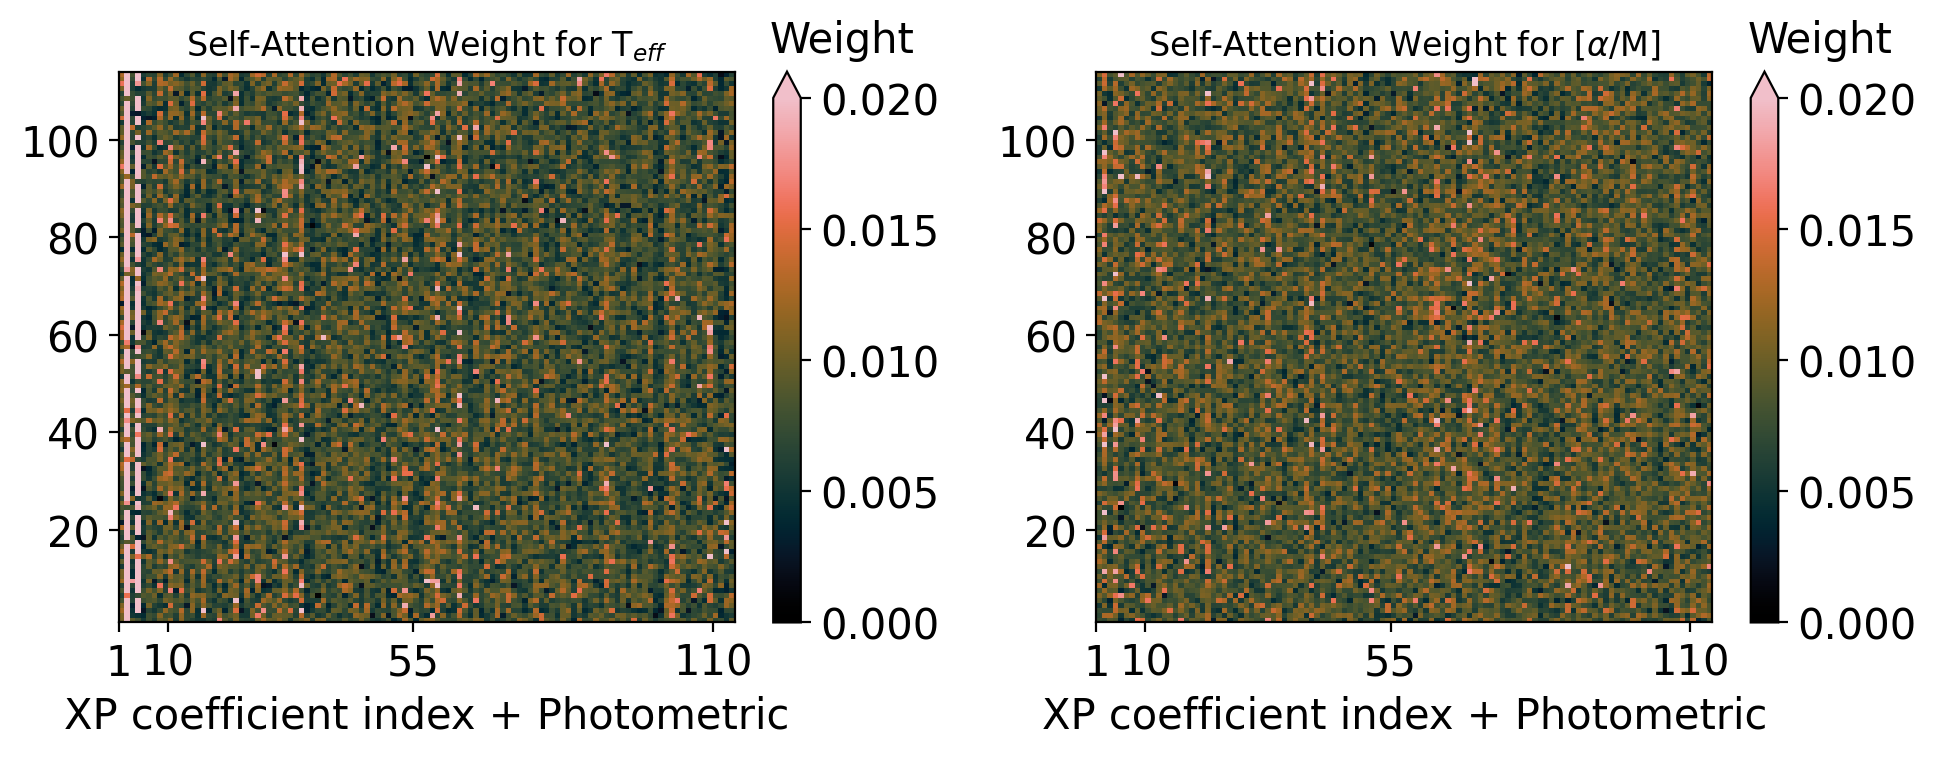

In [120]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

idx = 5
layer = 0
batch_idx = 0

ax1, ax2 = axs.ravel()
ax1 = draw_attention(teff_infer['attn'][batch_idx][layer][idx], ax1, vmax=0.02, cmap='cmr.dusk')
ax1.set_title(r"Self-Attention Weight for T$_{eff}$", fontsize=12);
ax1.set_xlabel("")

ax2 = draw_attention(aom_infer['attn'][batch_idx][layer][idx], ax2, vmax=0.02, cmap='cmr.dusk')
ax2.set_title(r"Self-Attention Weight for [$\alpha$/M]", fontsize=12);
plt.tight_layout()

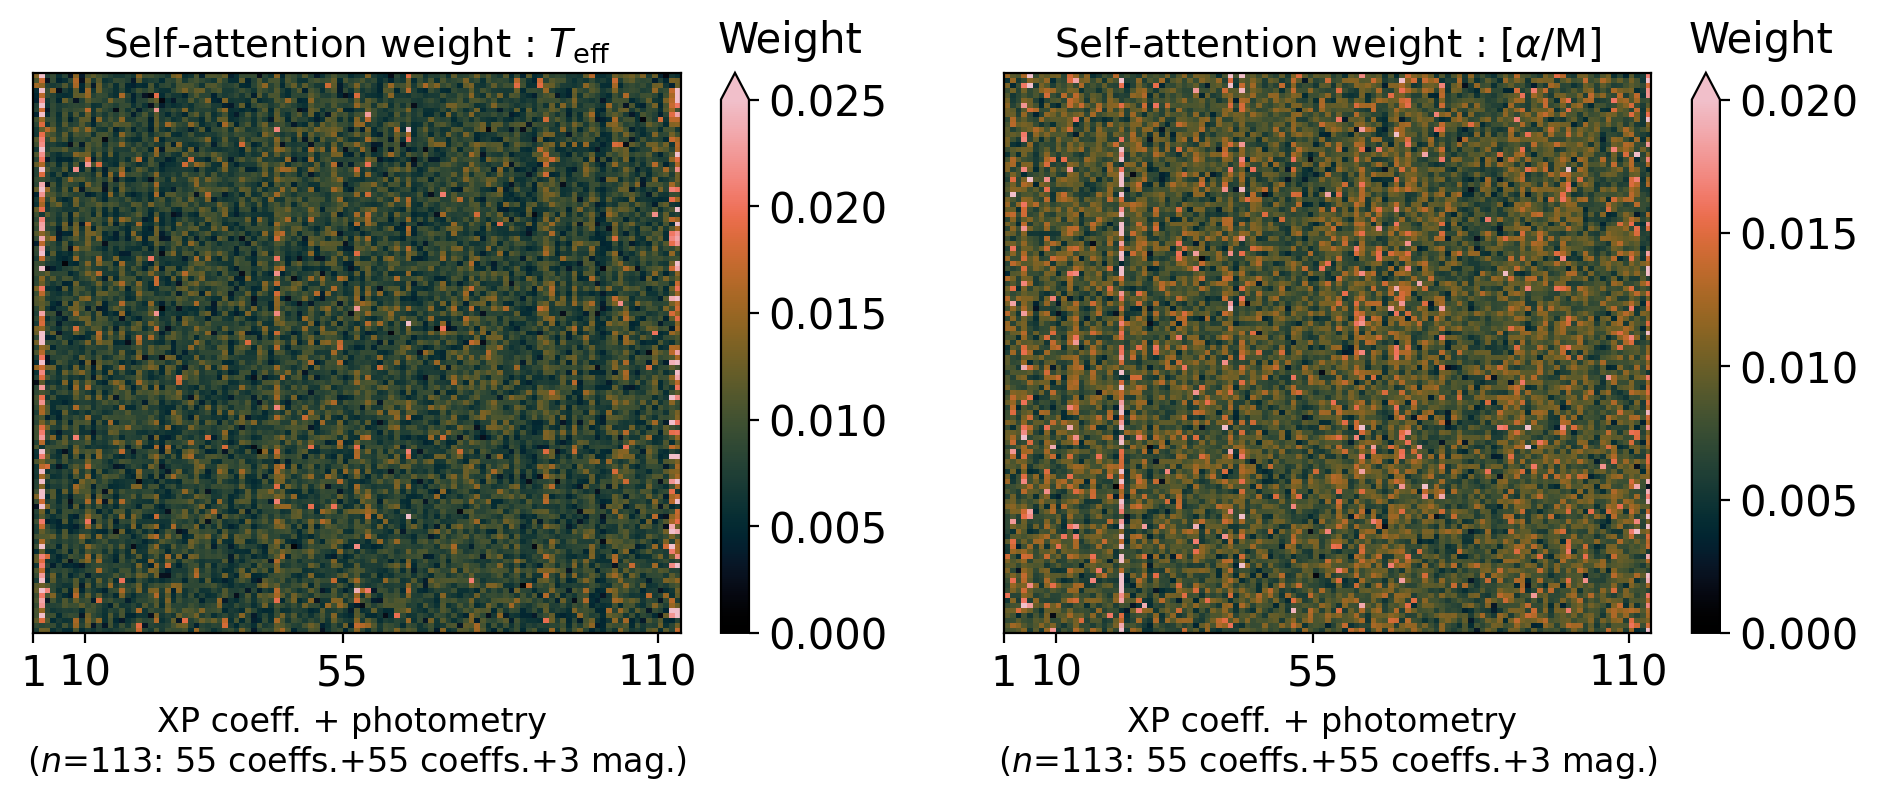

In [153]:
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)

idx = 5
layer = 1
batch_idx = 0

ax1, ax2 = axs.ravel()
ax1 = draw_attention(teff_infer['attn'][batch_idx][layer][idx], ax1, vmax=0.025, cmap='cmr.dusk')
ax1.set_title(r"Self-attention weight : $T_{\rm eff}$", fontsize=14);
ax1.set_xlabel("XP coeff. + photometry \n($n$=113: 55 coeffs.+55 coeffs.+3 mag.)", fontsize=12);
# ax1.set_ylabel("Query");
ax1.set_yticks([]);
ax1.set_yticklabels([]);

ax2 = draw_attention(aom_infer['attn'][batch_idx][layer][idx], ax2, vmax=0.02, cmap='cmr.dusk')
ax2.set_title(r"Self-attention weight : [$\alpha$/M]", fontsize=14);
ax2.set_xlabel("XP coeff. + photometry \n($n$=113: 55 coeffs.+55 coeffs.+3 mag.)", fontsize=12);
# ax2.set_ylabel("Query");

# plt.tight_layout()
fig.subplots_adjust(left=0.1, bottom=0.2, right=0.99, top=0.9, wspace=0.2, hspace=0.1)

fig.savefig("../fig/attn_weight.png")